In [381]:
import os
import random
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm.notebook import tqdm

import warnings
warnings.simplefilter("ignore")

In [382]:
class Config:
    seed = 1707
    test_size = 0.2

In [383]:
def set_all_seeds(seed):
    # python's seeds
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)

set_all_seeds(seed=Config.seed)

# 2.4.8

In [422]:
def check(target, metric='mean'):
    tmp = df.groupby(target, as_index=False)['target_reg'].agg(metric)
    sns.catplot(data = tmp, x = target, y = 'target_reg', aspect=2, kind="bar");

In [423]:
# Для тренировочного датасета сгенерируйте 10 номеров фолдов (от 0 и до 9) так, чтобы в каждом фолде среднее значение регрессионного таргета было примерно одинаковым
# Номер фолда запишите в новый столбец num_fold. Допускается разброс значений таргета между фолдами = 350 у.е
from sklearn.model_selection import StratifiedKFold

In [424]:
df = pd.read_csv('../data/02.4_stratified_valid.csv')
df.head()

,car_id,target_reg,num_fold
0,y13744087j,9492.96,NaN
1,O41613818T,2656.23,NaN
2,d-2109686j,1526.11,NaN
3,u29695600e,1338.00,NaN
4,N-8915870N,825.72,NaN


In [425]:
df.shape

(2337, 3)

In [426]:
N = 10

# StratifiedKFold умеет работать только с дискретными/целыми значениями.
# Делим таргет на N групп по которым и будем потом разбивать на фолды
df['target_reg_group'] = pd.qcut(df['target_reg'], N, labels = [f'group_{i}' for i in range(N)])
df['num_fold'] = None

In [419]:
df.pivot_table(index=['target_reg_group'], aggfunc={'target_reg':'sum'})

,target_reg
target_reg_group,
group_0,118894.35
group_1,201553.54
group_2,284390.52
group_3,385428.51
group_4,492580.17
group_5,618728.84
group_6,787860.67
group_7,1014542.15
group_8,1408579.34


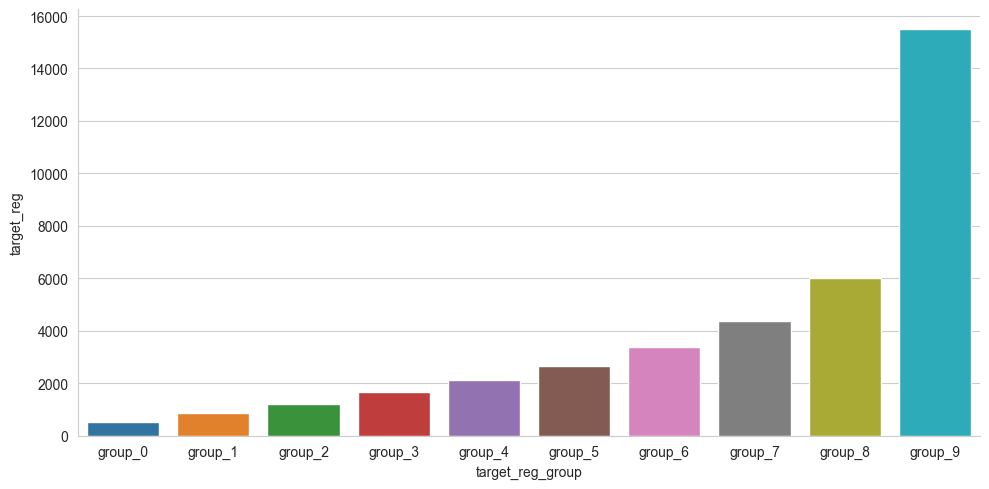

In [429]:
check('target_reg_group', metric='mean')

In [430]:
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=Config.seed)
for i, (train_index, test_index) in enumerate(skf.split(df, df['target_reg_group'])):
    df.loc[test_index, 'num_fold'] = i

In [431]:
df.groupby('num_fold', as_index=False)['target_reg'].agg('mean')['target_reg'].std()

280.3026722433518

In [432]:
df.pivot_table(index=['num_fold'], aggfunc={'target_reg':'sum'})

,target_reg
num_fold,
0,942347.52
1,873639.02
2,911531.62
3,830992.08
4,831606.86
5,801896.75
6,903912.81
7,1024386.07
8,895644.03


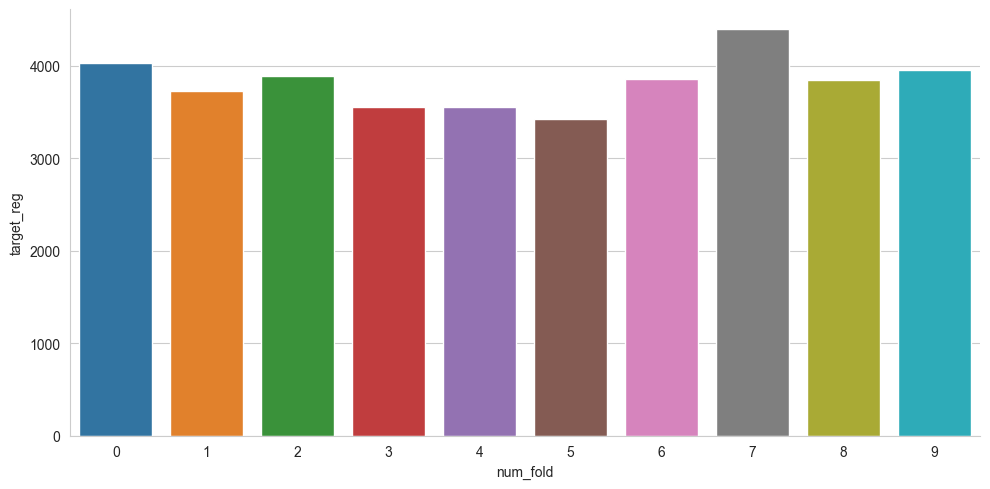

In [435]:
check('num_fold', metric='mean')

In [420]:
df

,car_id,target_reg,num_fold,target_reg_group
0,y13744087j,9492.96,None,group_9
1,O41613818T,2656.23,None,group_5
2,d-2109686j,1526.11,None,group_3
3,u29695600e,1338.00,None,group_2
4,N-8915870N,825.72,None,group_1
...,...,...,...,...
2332,j21246192N,547.30,None,group_0
2333,h-1554287F,26414.19,None,group_9
2334,A15262612g,2677.95,None,group_5
2335,W-2514493U,2213.63,None,group_4


In [395]:
df.shape

(2337, 4)

In [396]:
df.drop('target_reg_group', axis=1, inplace=True)

In [397]:
df.to_csv('../submissions/02.4_stratified_valid.csv', index=False)

# 2.4.9

In [398]:
# Для тренировочного датасета сгенерируйте 5 фолдов (от 0 и до 4) так, чтобы в каждом фолде число всех классов было примерно одинаковым (сбалансированным)
# Номер фолда запишите в новый столбец kfold. Допускается средний разброс значений таргета между фолдами хотя бы = 9.5 у.е
from iterstrat.ml_stratifiers import MultilabelStratifiedKFold


In [399]:
def check(df):
    tmp = df.groupby(['kfold'], as_index=False).sum()
    tmp_melt = tmp.melt(id_vars = 'kfold', value_vars = targets, value_name = 'count', var_name = 'class')
    print(tmp_melt.groupby(['class'], as_index=False).std()['count'].mean())

In [400]:
df = pd.read_csv('../data/02.4_multi_label.csv')
df.sample(3)

,ID,Computer Science,Physics,Mathematics,Statistics,Quantitative Biology,Quantitative Finance,Chemistry,Astrology,Spaceology,Life Science,Earth Science,Data Science
1425,4069,1,0,0,1,0,0,0,0,0,0,0,1
8888,5212,0,0,0,1,0,0,0,0,0,0,0,1
263,6795,1,0,1,0,0,0,0,0,0,1,0,0


In [401]:
targets = ['Computer Science', 'Physics', 'Mathematics', 'Statistics',
           'Quantitative Biology', 'Quantitative Finance', 'Chemistry',
           'Astrology', 'Spaceology', 'Life Science', 'Earth Science', 'Data Science']

In [402]:
# def create_folds(data, num_splits=3, targets = [0, 1, 2, 4]):
#     if num_splits > 1:
#         data['kfold'] = -1
#         X = data
#         y = data[targets]
#         mskf = MultilabelStratifiedKFold(n_splits=num_splits, shuffle=True, random_state=42)
#
#         for fold, (trn_, val_) in enumerate(mskf.split(X, y)):
#             data.loc[val_,'kfold'] = fold
#     else:
#         data.loc[:,'kfold'] = 0
#
#     return data

# create_folds(df)

In [403]:
# Вариант №1

# Выбираем вск категориальные фичи
df_arr = np.array(df[df.columns])[:, 1:]
# Переводим в строку все значения фичей и создаем группы
strs = [''.join(map(str, df_arr[i])) for i in range(len(df_arr))]
df['group'] = strs

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=Config.seed)
for i, (train_index, test_index) in enumerate(skf.split(df, df['group'])):

    df.loc[test_index, 'kfold'] = i

# Готовим данные к экспорту на платформу
df = df.drop(columns=['group'])
df['kfold'] = df['kfold'].apply(int)

In [404]:
check(df)

2.5235344051496296


In [405]:
# Вариант №2

# Выбираем вск категориальные фичи
targets = df.columns[1:].to_list()

# Заготовка под будущие фолды
df['kfold'] = -1

mskf = MultilabelStratifiedKFold(n_splits=5, shuffle=True, random_state=Config.seed)
for num, (train_index, test_index) in enumerate(mskf.split(df, df[targets])):
    df.loc[test_index, 'kfold'] = num

In [406]:
df.to_csv('../submissions/02.4_multi_label_2.csv', index=False)

# Questions

In [407]:
df = pd.read_csv('../data/02.4_stratified_valid.csv')
df.head()

,car_id,target_reg,num_fold
0,y13744087j,9492.96,NaN
1,O41613818T,2656.23,NaN
2,d-2109686j,1526.11,NaN
3,u29695600e,1338.00,NaN
4,N-8915870N,825.72,NaN


In [408]:
N = 10

# StratifiedKFold умеет работать только с дискретными/целыми значениями.
# Делим таргет на N групп по которым и будем потом разбивать на фолды
df['group'] = pd.qcut(df['target_reg'], N, labels = [f'group_{i}' for i in range(N)])
# df['num_fold'] = None

In [409]:
df

,car_id,target_reg,num_fold,group
0,y13744087j,9492.96,NaN,group_9
1,O41613818T,2656.23,NaN,group_5
2,d-2109686j,1526.11,NaN,group_3
3,u29695600e,1338.00,NaN,group_2
4,N-8915870N,825.72,NaN,group_1
...,...,...,...,...
2332,j21246192N,547.30,NaN,group_0
2333,h-1554287F,26414.19,NaN,group_9
2334,A15262612g,2677.95,NaN,group_5
2335,W-2514493U,2213.63,NaN,group_4


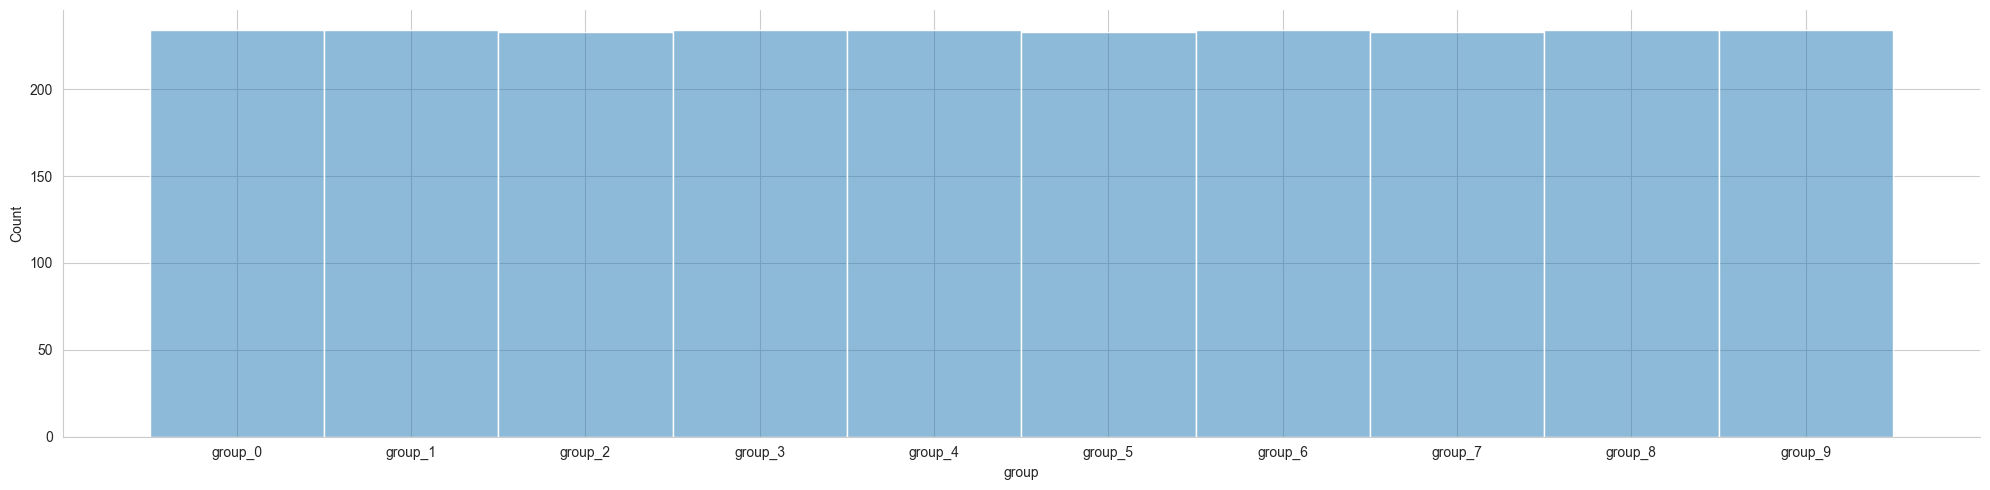

In [410]:
g = sns.displot(
    data=df,

    x="group",
    # y="user_time_accident",

    # hue="target_class",
    # legend=True,
    aspect=4,
    kind="hist",  # kde
    alpha=0.5,
);